## Geological Image Similarity Dataset
https://www.kaggle.com/tanyadayanand/geological-image-similarity

In [4]:
# Load usefull libraries and helper functions
# %run libs_and_utils
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import random

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [5]:
# Dataset consists of 6 folders each containing around 5k photographs
directory = r'input'
subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
for subfolder in subfolders:
    print(subfolder.split('\\')[1], ':', len(os.listdir(subfolder)), 'images')

andesite : 5000 images
gneiss : 5000 images
marble : 4998 images
quartzite : 5000 images
rhyolite : 5000 images
schist : 5000 images


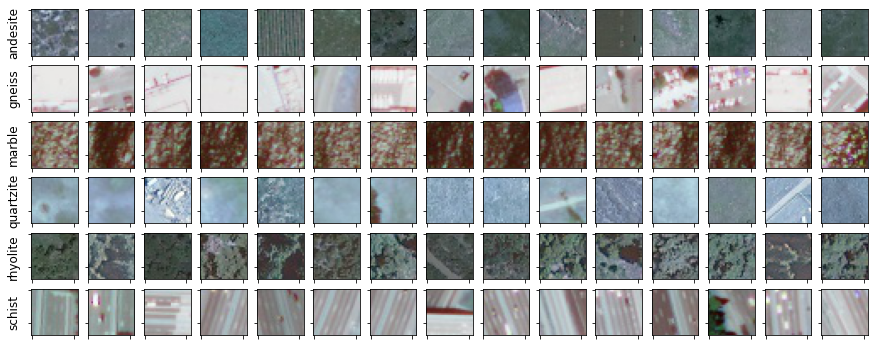

In [6]:
# Let's preview some randomly selected images of each class
n_show = 15

fig, axes = plt.subplots(len(subfolders), n_show, figsize = (n_show,6))
# Preview images:
for row_idx, subfolder in enumerate(subfolders):    
    filenames = [f.path for f in os.scandir(subfolder)]   
    files_to_preview = random.sample(filenames, n_show)
    for col_idx, path in enumerate(files_to_preview):
        image = mpimg.imread(path)
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_xticklabels([])
        axes[row_idx, col_idx].set_yticklabels([])

# Set labels:
for ax, row in zip(axes[:,0], subfolders):
    ax.set_ylabel(row.split('\\')[1], rotation=90, size='large')

plt.show()

In [45]:
# Let's transform our dataset to torch datasets:

class GeologicalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform # what transforms were passed to the initialiser
        
        self.img_names = [os.path.join(path, name) for path, subdirs, files in os.walk(root_dir) for name in files]
        
        label_to_idx = {
            'andesite': 0,
            'gneiss': 1,
            'marble': 2,
            'quartzite': 3,
            'rhyolite': 4,
            'schist': 5
            }

        self.labels = [label_to_idx[os.path.join(path, name).split('\\')[1]] for path, subdirs, files in os.walk(root_dir) for name in files]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):        
        image = mpimg.imread(self.img_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    #transforms.ToPILImage(), # because the input dtype is numpy.ndarray
    #transforms.RandomHorizontalFlip(0.5), # because this method is used for PIL Image dtype
    transforms.ToTensor(), # because inpus dtype is PIL Image
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = GeologicalDataset('input',transform=transform)#, transform = transforms.Compose([transforms.ToTensor()]))

train_set, test_set = torch.utils.data.random_split(dataset, [24998, 5000], generator=torch.Generator().manual_seed(42))

print(len(dataset), len(train_set), len(test_set))

29998 24998 5000


torch.float32
torch.Size([3, 28, 28])
4


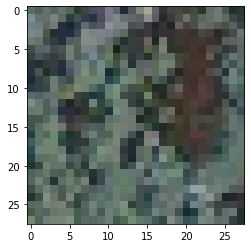

In [46]:
image, label = next(iter(train_set))
print(image.dtype)
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
print(label)

In [61]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(in_features=2304, out_features=512),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=512, out_features=128),
            nn.Linear(in_features=128, out_features=6),
            )
        
    def forward(self, x):
        return self.nn(x)


model = CNN()

loss_func = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

CNN(
  (nn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=2304, out_features=512, bias=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Linear(in_features=512, out_features=128, bias=True)
    (12): Linear(in_features=128, out_features=6, bias=True)
  )
)


100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


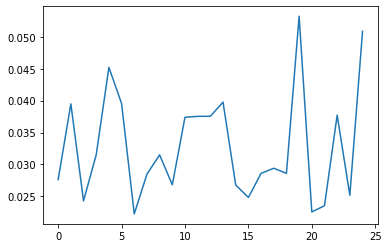

Wall time: 37.4 s


In [97]:
%%time

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
                                    

# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []
# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

num_epochs = 1
count = 0
#for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):
        model.train()
        #images = Variable(images)
        #labels = Variable(labels)
        loss = loss_func(model(images), labels)
        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()
        loss_list.append(loss)
    plt.plot(loss_list)
    plt.show()
    #print('epoch:', epoch, 'loss:', loss.value())   
    
    # Testing the model    
    '''if ct % 50 == 0:   # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
            for images, labels in test_loader:
                model.eval()
                #print(images.shape, labels.shape)
                labels_list.append(labels)
            
                #test = Variable(images.view(64, 3, 28, 28))
                outputs = model(images.view(64,3,28,28))
            
                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100//total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 10):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))'''